# Transfer learning of a deep CNN on XPS data on Google Colab

In this notebook, we will use transfer learning for training a deep convolutional network on new XPS spectra using a pre-trained model. Using Google Colab.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Install packages and import modules

In [2]:
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

     |████████████████████████████████| 5.5MB 7.2MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=700c1dba957c67343c24830419a5dd8678d27e68df68efbc96c0f1b8efb278cb
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


### Load custom modules

In [3]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(models)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.models as models
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Setting up the parameters & folder structure

In [4]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_single_4_classes_transfer'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierSingle(time = time,
                                  data_name = data_name,
                                  labels = label_values)

Model folder created at /saved_models/20200701_09h14m_Fe_single_4_classes_transfer
Logs folder created at /logs/20200701_09h14m_Fe_single_4_classes_transfer
Figures folder created at /figures/20200701_09h14m_Fe_single_4_classes_transfer


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


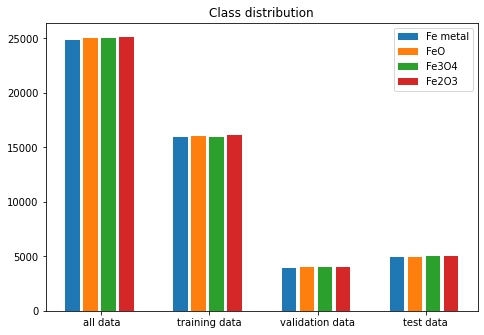

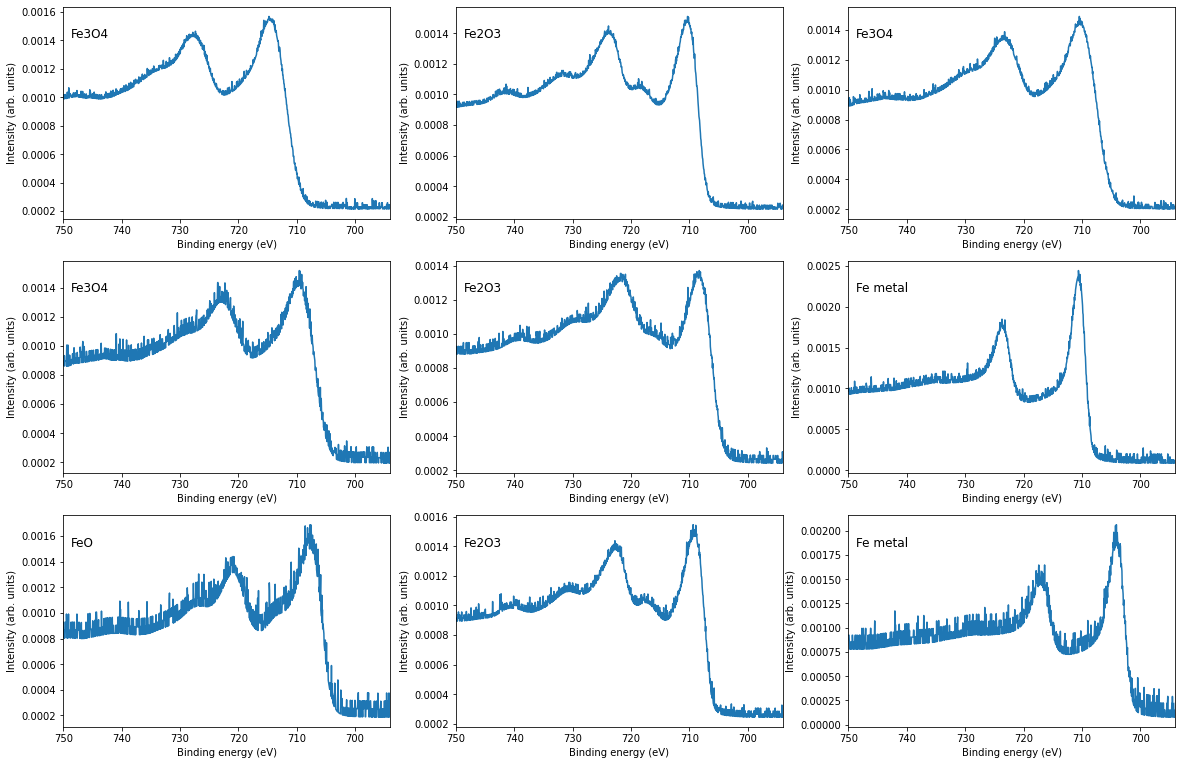

In [5]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200605_iron_single_small.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test = clf.load_data_preprocess(input_filepath = input_filepath,
                                                                          no_of_examples = no_of_examples,
                                                                          train_test_split = train_test_split,
                                                                          train_val_split = train_val_split)
# Check how the examples are distributed across the classes:
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

## Load pre-trained model

### Load model without classification layers

In [6]:
clf.load_model(model_path = r'/content/drive/My Drive/app/saved_models/20200629_23h27m_Fe_single_4_classes',
               drop_last_layers = 2)
clf.summary()

Loaded model from disk.
The last 2 layers were dropped.

Model: "Changed_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1121, 4)      24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1121, 4)      44          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1121, 4)      64          input_2[0][0]                    
_____________________________

In [7]:
clf.model.trainable = False

### Add new classification layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

dense_1 = Dense(500, activation = 'relu')(clf.model.layers[-1].output)
dense_2 = Dense(clf.num_classes, activation = 'softmax')(dense_1)
clf.model = models.EmptyModel(inputs = clf.model.input,
                        outputs = dense_2,
                        inputshape = clf.input_shape,
                        num_classes = clf.num_classes,
                        no_of_inputs = clf.model.get_config()['no_of_inputs'],
                        name = 'Changed_Model')

### Compile and summarize the model

Model: "Changed_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1121, 4)      24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1121, 4)      44          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1121, 4)      64          input_2[0][0]                    
______________________________________________________________________________________

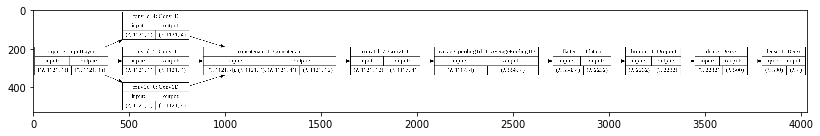

In [9]:
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 

clf.model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer, 
                  metrics = ['accuracy'])


# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Training

In [10]:
epochs = 150
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/150
2000/2000 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.4094WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200701_09h14m_Fe_single_4_classes_transfer/assets
2000/2000 [==============================] - 76s 38ms/step - loss: 1.3229 - accuracy: 0.4094 - val_loss: 1.2699 - val_accuracy: 0.4470
Epoch 2/150
2000/2000 [==============================] - 76s 38ms/step - loss: 1.2301 - accuracy: 0.4876 - val_loss: 1.1916 - val_accuracy: 0.5486
Epoch 3/150
2000/2000 [==============================] - 75s 38ms/step - loss: 1.1531 - accuracy: 0.5715 - val_loss: 1.1145 - val_accur

### Graphs

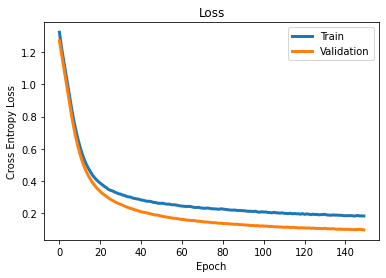

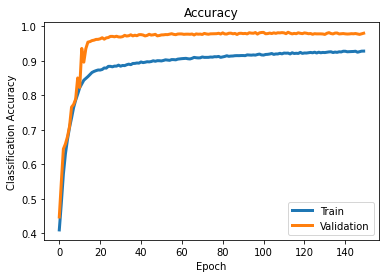

In [11]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name) 
graph.plot_loss()
graph.plot_accuracy()

### Evaluation on test data

In [12]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

625/625 [==============================] - 17s 27ms/step - loss: 0.0946 - accuracy: 0.9820
Evaluation done! 

Test loss: 0.095
Test accuracy: 0.982


### Prediction on test data

In [13]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

625/625 [==============================] - 17s 27ms/step
Prediction done!
Class prediction done!


### Show some predictions

#### Training data

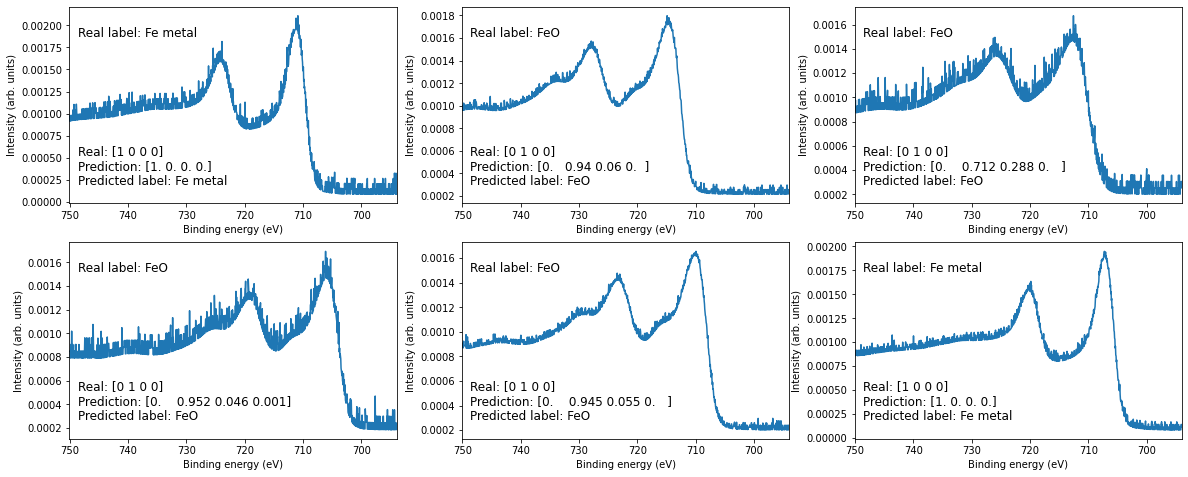

In [14]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### Test data

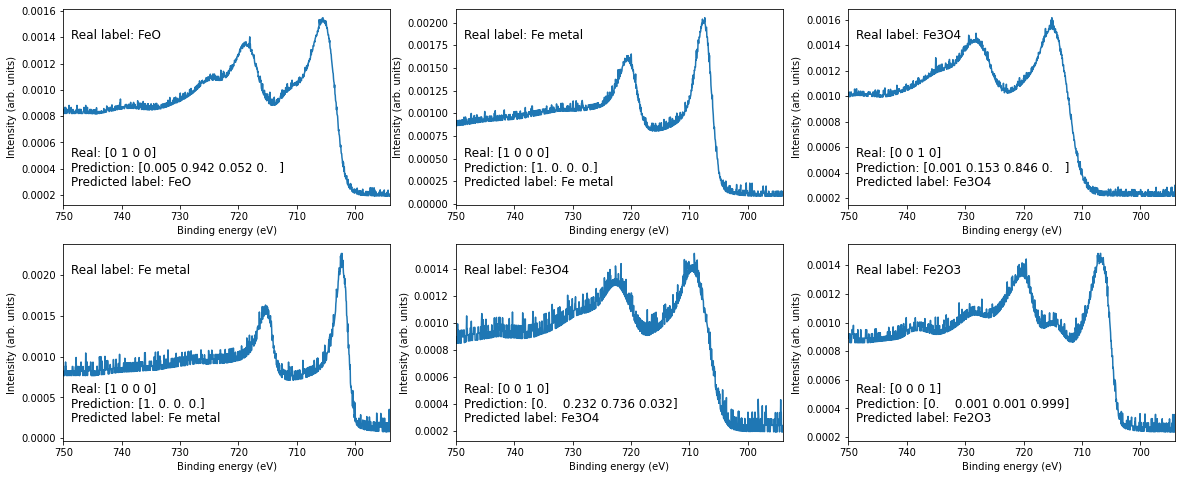

In [15]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Show wrong predictions

In [19]:
clf.show_wrong_classification()

No. of wrong predictions on the test data: 0


### Saving data

In [16]:
clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200701_09h14m_Fe_single_4_classes_transfer/assets
Saved model to disk.
Saved hyperparameters to file.
Saved results to file.


### Report

In [17]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

Report saved!


### Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time

save_notebook()
time.sleep(3)
current_file = 'transfer_learning_single.ipynb'
output_file = os.path.join(clf.log_dir,'transfer_learning_single_out.html')
output_HTML(current_file, output_file)